# Getting started with hillmaker

In this tutorial we'll focus on basic use of hillmaker for analyzing arrivals, departures, and occupancy by time of day and day of week for a typical *discrete entity flow system*. A few examples of such systems include:

- patients arriving, undergoing some sort of care process and departing some healthcare system (e.g. emergency department, surgical recovery, nursing unit, outpatient clinic, and many more)
- customers renting, using, and returning bikes in a bike share system,
- users of licensed software checking out, using, checking back in a software license,
- products undergoing some sort of manufacturing or assembly process - occupancy is WIP,
- patrons arriving, dining and leaving a restaurant,
- travelers renting, residing in, and checking out of a hotel,
- flights taking off and arriving at their destination,
- ...

Basically, any sort of discrete [stock and flow system](https://en.wikipedia.org/wiki/Stock_and_flow) for which you are interested in time of day and day of week specific statistical summaries of occupancy, arrivals and departures, and have raw data on the arrival and departure times, is fair game for hillmaker.

## Installation

You can use pip to install hillmaker into the Python virtual environment of your choice.

```
pip install hillmaker
```

## Ways of using hillmaker

There are currently three ways of using hillmaker. 

1. Command line interface (CLI)
2. An object oriented API in Python
3. Calling a single Python function

The plan is to add a fourth option:

4. Through a GUI interface (not implemented yet)

Depending on your level of comfort with Python, you can choose the method that works best for you. This Getting Started tutorial will demo all three ways of using hillmaker and subsequent tutorials will go into more detail. There are numerous input parameters that can be used to customize the behavior of hillmaker and we'll only touch on a few in this tutorial.

## Module imports
To run hillmaker we only need to import a few modules. Often we will be using pandas as part of our analysis and we'll import that as well. 

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import pandas as pd
import hillmaker as hm

## A prototypical example - occupancy analysis of a hospital Short Stay Unit

Patients flow through a short stay unit (SSU) for a variety of procedures, tests or therapies. Let's assume patients can be classified into one of five categories of patient types: ART (arterialgram), CAT (post cardiac-cath), MYE (myelogram), IVT (IV therapy), and OTH (other). We are interested in occupancy statistics by time of day and day of week to support things like staff scheduling and capacity planning.

From one of our hospital information systems we were able to get raw data about the entry and exit times of each patient and exported the data to a csv file. We call each row of such data a *stop* (as in, the patient stopped here for a while). Let's take a peek at the data by first reading the csv file into a pandas `DataFrame`.

In [17]:
ssu_stopdata = './data/ssu_2024.csv'
stops_df = pd.read_csv(ssu_stopdata, parse_dates=['InRoomTS','OutRoomTS'])
stops_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59877 entries, 0 to 59876
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PatID      59877 non-null  int64         
 1   InRoomTS   59877 non-null  datetime64[ns]
 2   OutRoomTS  59877 non-null  datetime64[ns]
 3   PatType    59877 non-null  object        
 4   LOS_hours  59877 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


In [4]:
stops_df.head()

,PatID,InRoomTS,OutRoomTS,PatType,LOS_hours
0,1,2024-01-01 07:44:00,2024-01-01 09:20:00,IVT,1.600000
1,2,2024-01-01 08:28:00,2024-01-01 11:13:00,IVT,2.750000
2,3,2024-01-01 11:44:00,2024-01-01 12:48:00,MYE,1.066667
3,4,2024-01-01 11:51:00,2024-01-01 21:10:00,CAT,9.316667
4,5,2024-01-01 12:10:00,2024-01-01 12:57:00,IVT,0.783333


Before running hillmaker, we need to know the timeframe for which we have data. 

In [5]:
stops_df['InRoomTS'].min()

Timestamp('2024-01-01 07:44:00')

In [6]:
stops_df['InRoomTS'].max()

Timestamp('2024-09-30 22:45:00')

Looks like we have data from Jan through Sept of 2024. Since patients usually stay for less than 24 hours in an SSU, we'll do our occupancy analysis starting on January 2, 2024 (since the 1st is a holiday) and ending on September 30, 2024. Later in the tutorial we'll discuss the important issues of choosing an appropriate analysis timeframe and *horizon effects*. 

As part of an operational analysis we would like to compute a number of relevant statistics, such as:

- mean and 95th percentile of overall SSU occupancy by hour of day and day of week,
- similar hourly statistics for patient arrivals and departures,
- all of the above but by patient type as well.

In addition to tabular summaries, let's make some plots showing the mean and 95th percentile of occupancy by time of day and day of week.

## Running hillmaker via the command line interface (CLI)

To run hillmaker from the command line, make sure that you are using whatever virtual environment within which hillmaker is installed. Let's see the help for hillmaker's CLI:

In [7]:
!hillmaker -h

usage: hillmaker [--scenario_name SCENARIO_NAME] [--data DATA]
                 [--in_field IN_FIELD] [--out_field OUT_FIELD]
                 [--start_analysis_dt START_ANALYSIS_DT]
                 [--end_analysis_dt END_ANALYSIS_DT] [--config CONFIG]
                 [--cat_field CAT_FIELD] [--bin_size_minutes BIN_SIZE_MINUTES]
                 [--cats_to_exclude [CATS_TO_EXCLUDE ...]]
                 [--occ_weight_field OCC_WEIGHT_FIELD]
                 [--percentiles [PERCENTILES ...]] [--los_units LOS_UNITS]
                 [--csv_export_path CSV_EXPORT_PATH] [--no_dow_plots]
                 [--no_week_plots] [--plot_export_path PLOT_EXPORT_PATH]
                 [--plot_style PLOT_STYLE] [--figsize FIGSIZE FIGSIZE]
                 [--bar_color_mean BAR_COLOR_MEAN]
                 [--plot_percentiles PLOT_PERCENTILES [PLOT_PERCENTILES ...]]
                 [--pctile_color PCTILE_COLOR [PCTILE_COLOR ...]]
                 [--pctile_linestyle PCTILE_LINESTYLE [PCTILE_LINESTY

There are several required arguments: 

- SCENARIO_NAME - a scenario name, 
- DATA - the path to the csv file containing the stop data, 
- IN_FIELD, OUT_FIELD - the field names containing the arrival times and the departure times, 
- START_ANALYSIS_DT, END_ANALYSIS_DT - starting and ending dates for the analysis.

There are also numerous optional arguments controlling how hillmaker works and which outputs are created.

Let's run hillmaker by specifying the required arguments as well as an output path for plots and csv files. The stop data file, `ssu_2024.csv` is in the `data` folder. We'll output plots and csv summary files to the `output` folder. Typically, we would also specify a category field - in this case it would be `PatType`. We'll use 60 minutes for the time bin size. 



By default, hillmaker prints out several informational messages. You can suppress these with `--verbosity 0`. You can get even more detailed status messages (useful for debugging) by using `--verbosity 2`.

In [9]:
!hillmaker --scenario cli_demo_ssu_60 --data ./data/ssu_2024.csv \
--in_field InRoomTS --out_field OutRoomTS --cat_field PatType --bin_size_minutes 60 \
--start_analysis_dt 2024-01-02 --end_analysis_dt 2024-09-30 --csv_export_path output --plot_export_path output --ylabel Patients 

2023-10-24 20:13:26,291 - hillmaker.hills - INFO - Starting scenario cli_demo_ssu_60
2023-10-24 20:13:34,937 - hillmaker.summarize - INFO - Created nonstationary summaries - ['PatType']
2023-10-24 20:13:36,038 - hillmaker.summarize - INFO - Created nonstationary summaries - []
2023-10-24 20:13:36,071 - hillmaker.summarize - INFO - Created stationary summaries - ['PatType']
2023-10-24 20:13:36,082 - hillmaker.summarize - INFO - Created stationary summaries - []
2023-10-24 20:13:37,511 - hillmaker.hills - INFO - bydatetime and summaries by datetime created (seconds): 11.1995
2023-10-24 20:13:37,750 - hillmaker.hills - INFO - By datetime exported to csv in output (seconds): 0.2391
2023-10-24 20:13:37,823 - hillmaker.hills - INFO - Summaries exported to csv in output (seconds): 0.0731
2023-10-24 20:13:40,000 - hillmaker.plotting - INFO - Full week plots created (seconds): 2.1767
2023-10-24 20:13:48,685 - hillmaker.plotting - INFO - Individual day of week plots created (seconds): 8.6845
202

## CSV file outputs
When you use the CLI, CSV versions of the output tables are exported to `CSV_EXPORT_PATH`.

In [3]:
!ls output/cli_demo_ssu_60*.csv

output/cli_demo_ssu_60_arrivals.csv
output/cli_demo_ssu_60_arrivals_dow_binofday.csv
output/cli_demo_ssu_60_arrivals_PatType.csv
output/cli_demo_ssu_60_arrivals_PatType_dow_binofday.csv
output/cli_demo_ssu_60_bydatetime_datetime.csv
output/cli_demo_ssu_60_bydatetime_PatType_datetime.csv
output/cli_demo_ssu_60_departures.csv
output/cli_demo_ssu_60_departures_dow_binofday.csv
output/cli_demo_ssu_60_departures_PatType.csv
output/cli_demo_ssu_60_departures_PatType_dow_binofday.csv
output/cli_demo_ssu_60_occupancy.csv
output/cli_demo_ssu_60_occupancy_dow_binofday.csv
output/cli_demo_ssu_60_occupancy_PatType.csv
output/cli_demo_ssu_60_occupancy_PatType_dow_binofday.csv


There are four groups of files, each beginning with the scenario name `'cli_demo_ssu_60'`. 

- `occupancy`, `arrivals`, `departures` - summary statistics for occupancy, arrivals and departures
- `bydatetime` - number of arrivals, departures and occupancy level by datetime bin over the analysis range (e.g. individual hours on each date)

Usually it's the occupancy summaries that we are most interested in. From each occupancy related filename, we can infer the grouping levels used for the summary statistics.

### \<scenario name\>_occupancy_dow_binofday.csv

This is probably the most used summary as it gives us overall occupancy statistics by time bin of day (in this case, hourly) and day of week. We can read it into a pandas `DataFrame` and take a look. Since we used hourly time bins, there will be 168 rows in the summary. Numerous summary statistics are computed for each hour of the week.

In [10]:
occ_dow_binofday_df = pd.read_csv('output/cli_demo_ssu_60_occupancy_dow_binofday.csv')
occ_dow_binofday_df.head(30)


,day_of_week,dow_name,bin_of_day,bin_of_day_str,count,mean,min,max,stdev,sem,var,cv,skew,kurt,p25,p50,p75,p95,p99
0,0,Mon,0,00:00,39.0,1.561966,0.000000,4.666667,1.337969,0.214246,1.790160,0.856593,0.863336,-0.009379,0.533333,1.000000,2.000000,4.353333,4.616000
1,0,Mon,1,01:00,39.0,1.530342,0.000000,5.000000,1.314454,0.210481,1.727791,0.858929,1.123432,0.861793,0.783333,1.000000,2.000000,4.450000,4.905000
2,0,Mon,2,02:00,39.0,1.364103,0.000000,4.950000,1.194374,0.191253,1.426528,0.875575,1.089267,1.091913,0.950000,1.000000,2.000000,3.578333,4.582667
3,0,Mon,3,03:00,39.0,1.232479,0.000000,4.400000,1.058411,0.169481,1.120233,0.858766,0.875510,0.792365,0.350000,1.000000,1.991667,3.040000,4.020000
4,0,Mon,4,04:00,39.0,1.076068,0.000000,3.900000,0.971568,0.155575,0.943944,0.902887,0.893486,0.663040,0.000000,1.000000,1.600000,2.940000,3.558000
5,0,Mon,5,05:00,39.0,2.229915,0.083333,4.700000,1.138399,0.182290,1.295953,0.510513,0.442054,-0.335741,1.508333,2.000000,2.691667,4.178333,4.598667
6,0,Mon,6,06:00,39.0,15.443162,0.333333,21.483333,3.931664,0.629570,15.457978,0.254589,-2.423603,7.778248,14.616667,16.083333,17.241667,19.630000,21.166667
7,0,Mon,7,07:00,39.0,29.869658,1.533333,38.966667,7.498266,1.200683,56.223989,0.251033,-2.669468,8.294117,28.625000,31.433333,33.708333,36.283333,38.346000
8,0,Mon,8,08:00,39.0,39.738889,1.683333,56.650000,10.724470,1.717290,115.014259,0.269873,-2.304590,6.600737,36.925000,42.650000,45.366667,49.335000,54.218000
9,0,Mon,9,09:00,39.0,58.750000,1.483333,79.116667,15.509799,2.483556,240.553874,0.263997,-2.538838,7.735264,57.241667,61.283333,66.858333,74.036667,77.311667


From the `count` field we can see that there were 39 Mondays in the analysis date range. It is this `DataFrame` that used to create the weekly and day of week plots.

Plots are created in PNG format and exported to `PLOT_EXPORT_PATH`.

In [11]:
!ls output/cli_demo_ssu_60*occupancy*.png

output/cli_demo_ssu_60_occupancy_fri.png
output/cli_demo_ssu_60_occupancy_mon.png
output/cli_demo_ssu_60_occupancy_sat.png
output/cli_demo_ssu_60_occupancy_sun.png
output/cli_demo_ssu_60_occupancy_thu.png
output/cli_demo_ssu_60_occupancy_tue.png
output/cli_demo_ssu_60_occupancy_wed.png
output/cli_demo_ssu_60_occupancy_week.png


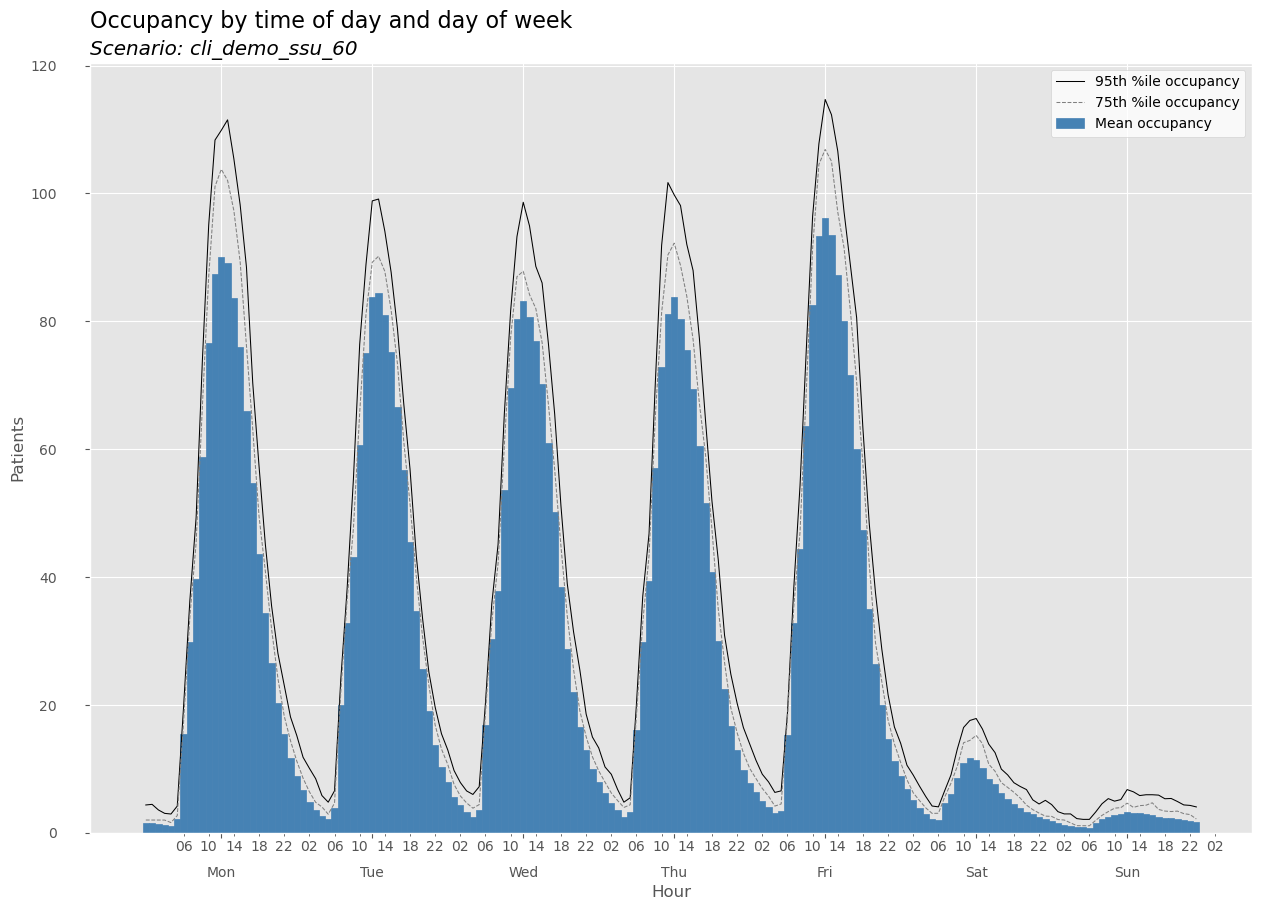

In [4]:
from IPython.display import Image
Image('output/cli_demo_ssu_60_occupancy_week.png')

There are also day of week specific plots.

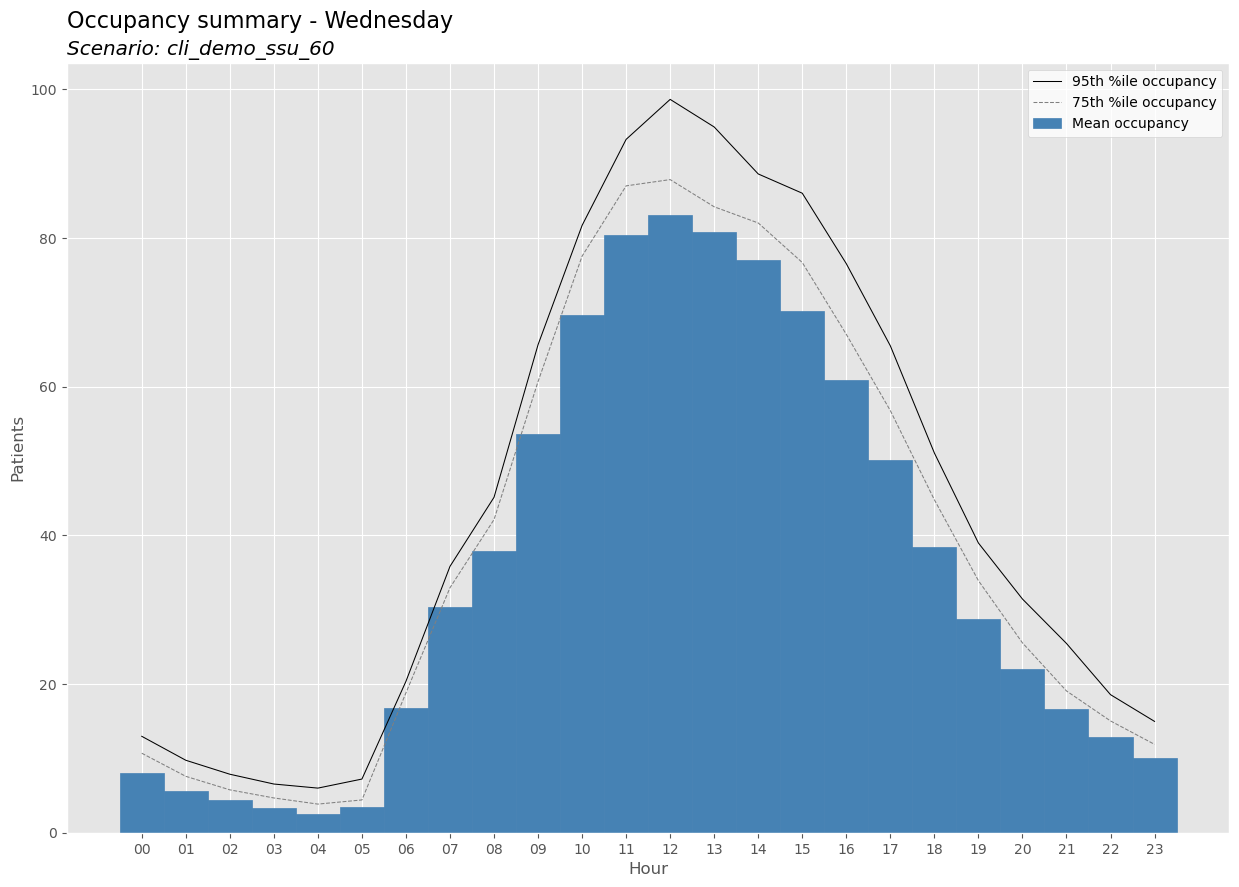

In [5]:
Image('output/cli_demo_ssu_60_occupancy_wed.png')

### \<scenario name\>_PatType_dow_binofday.csv

This is the most detailed summary as it is grouped by category (patient type in this example), day of week and hour of day.  This `DataFrame` is useful for seeing how individual patient types contribute to overall occupancy in the SSU. 


In [11]:
occ_PatType_dow_binofday_df = pd.read_csv('output/cli_demo_ssu_60_occupancy_PatType_dow_binofday.csv')
occ_PatType_dow_binofday_df.iloc[50:75]


,PatType,day_of_week,dow_name,bin_of_day,bin_of_day_str,count,mean,min,max,stdev,sem,var,cv,skew,kurt,p25,p50,p75,p95,p99
50,ART,2,Wed,2,02:00,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
51,ART,2,Wed,3,03:00,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
52,ART,2,Wed,4,04:00,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
53,ART,2,Wed,5,05:00,39.0,0.358120,0.000000,1.333333,0.377373,0.060428,0.142410,1.053762,1.100851,0.604813,0.008333,0.250000,0.575000,1.180000,1.320667
54,ART,2,Wed,6,06:00,39.0,3.672222,1.683333,5.716667,1.031559,0.165182,1.064113,0.280909,0.059364,-0.694543,3.008333,3.516667,4.408333,5.183333,5.628000
55,ART,2,Wed,7,07:00,39.0,7.820940,4.966667,10.633333,1.385444,0.221849,1.919455,0.177145,0.012103,-0.394016,6.900000,7.600000,8.875000,9.788333,10.614333
56,ART,2,Wed,8,08:00,39.0,10.516239,6.466667,15.383333,2.184222,0.349755,4.770826,0.207700,0.452734,-0.204397,9.291667,10.083333,11.633333,14.235000,15.237667
57,ART,2,Wed,9,09:00,39.0,12.370940,6.833333,20.316667,2.871884,0.459869,8.247715,0.232148,0.561270,0.441556,10.591667,12.000000,14.108333,17.330000,19.341333
58,ART,2,Wed,10,10:00,39.0,13.094017,8.250000,22.400000,2.954995,0.473178,8.731995,0.225675,0.862908,1.336721,11.350000,12.716667,15.008333,17.261667,21.114333
59,ART,2,Wed,11,11:00,39.0,13.336752,7.683333,21.333333,2.775359,0.444413,7.702620,0.208099,0.999808,1.666926,11.916667,12.766667,14.266667,19.376667,20.909000


The other two occupancy related csv files are summaries aggregated over time. One, `cli_demo_ssu_60_occupancy_PatType.csv`, is grouped by the category field and the other, `cli_demo_ssu_60_occupancy.csv`, is aggregated both over time and category.


In [12]:
occ_PatType_df = pd.read_csv('output/cli_demo_ssu_60_occupancy_PatType.csv')
occ_PatType_df


,PatType,count,mean,min,max,stdev,sem,var,cv,skew,kurt,p25,p50,p75,p95,p99
0,ART,6552.0,3.498013,0.0,22.400000,5.156624,0.063706,26.590766,1.474158,1.250915,0.230793,0.000000,0.000000,6.950000,14.250000,17.565667
1,CAT,6552.0,8.048838,0.0,34.383333,7.812497,0.096517,61.035116,0.970637,0.912114,-0.259791,1.616667,4.983333,13.716667,23.290833,28.274167
2,IVT,6552.0,10.076318,0.0,54.733333,13.459828,0.166285,181.166964,1.335788,1.205648,0.088333,0.033333,2.283333,18.408333,38.200000,45.500000
3,MYE,6552.0,1.971853,0.0,13.483333,2.902841,0.035862,8.426486,1.472138,1.364864,0.662152,0.000000,0.000000,3.533333,8.216667,10.308167
4,OTH,6552.0,4.567918,0.0,27.000000,5.687160,0.070260,32.343793,1.245022,1.072276,0.039763,0.000000,1.550000,8.533333,15.866667,19.891500


In [13]:
occ_df = pd.read_csv('output/cli_demo_ssu_60_occupancy.csv')
occ_df


,index,count,mean,min,max,stdev,sem,var,cv,skew,kurt,p25,p50,p75,p95,p99
0,1,6552.0,28.16294,0.0,121.533333,31.066525,0.383801,965.128949,1.103099,0.976111,-0.409349,3.316667,12.525,50.266667,89.83,105.0575


### The bydatetime files
The remaining CSV files provided detailed occupancy, arrival and departures values for every time bin over the entire analysis range. For example, here's what `cli_demo_ssu_60_bydatetime_datetime.csv` looks like.

In [15]:
bydatetime_df = pd.read_csv('output/cli_demo_ssu_60_bydatetime_datetime.csv')
bydatetime_df.head(15)


,datetime,arrivals,departures,occupancy,dow_name,bin_of_day_str,day_of_week,bin_of_day,bin_of_week
0,2024-01-02 00:00:00,0.0,0.0,1.000000,Tue,00:00,1,0,24
1,2024-01-02 01:00:00,0.0,1.0,0.883333,Tue,01:00,1,1,25
2,2024-01-02 02:00:00,0.0,0.0,0.000000,Tue,02:00,1,2,26
3,2024-01-02 03:00:00,0.0,0.0,0.000000,Tue,03:00,1,3,27
4,2024-01-02 04:00:00,0.0,0.0,0.000000,Tue,04:00,1,4,28
5,2024-01-02 05:00:00,0.0,0.0,0.000000,Tue,05:00,1,5,29
6,2024-01-02 06:00:00,6.0,0.0,1.983333,Tue,06:00,1,6,30
7,2024-01-02 07:00:00,16.0,1.0,12.650000,Tue,07:00,1,7,31
8,2024-01-02 08:00:00,11.0,5.0,24.283333,Tue,08:00,1,8,32
9,2024-01-02 09:00:00,25.0,3.0,35.350000,Tue,09:00,1,9,33


Notice that the occupancy field contains non-integer values. This is by design. For now, it is enough to say that occupancy in each time bin is proportional to the time a patient spent in the system during that time bin. For example, if a patient arrives at 7:15a and departs at 9:30a, then their contribution to occupancy in the `bydatetime` dataframe is:

| time bin  |occupancy   |
|---|---|
|07-08   | 0.75  |
| 08-09  | 1.00  |
| 09-10  | 0.50  |

For all the details on how hillmaker computes occupancy and options for controlling those computations, see {doc}`topic guide on occupancy computation <computing_occupancy>`.

## Using the `make_hills` function

Before the creation of the object-oriented API, hillmaker could be used by calling a single, module level, function called `make_hills`. This type of legacy use is still possible. The `make_hills` function returns a dictionary containing DataFrames and plots along with a few other items. We'll use the same example but will use two-hour time bins. 

Like the CLI, the legacy `make_hills` function can create and explort all plots as well the dataframes as CSV files. This behavior can be more finely controlled through input arguments. See {doc}`using_make_hills` for all the details.

Notice that since we already read the CSV data into a pandas `DataFrame` named `stops_df`, we can use that for the `data=` argument.


2023-10-24 20:16:45,857 - hillmaker.hills - INFO - Starting scenario func_demo_ssu_120
2023-10-24 20:16:50,947 - hillmaker.summarize - INFO - Created nonstationary summaries - ['PatType']
2023-10-24 20:16:51,513 - hillmaker.summarize - INFO - Created nonstationary summaries - []
2023-10-24 20:16:51,543 - hillmaker.summarize - INFO - Created stationary summaries - ['PatType']
2023-10-24 20:16:51,562 - hillmaker.summarize - INFO - Created stationary summaries - []
2023-10-24 20:16:52,841 - hillmaker.hills - INFO - bydatetime and summaries by datetime created (seconds): 6.9659
2023-10-24 20:16:52,971 - hillmaker.hills - INFO - By datetime exported to csv in ./output (seconds): 0.1296
2023-10-24 20:16:53,014 - hillmaker.hills - INFO - Summaries exported to csv in ./output (seconds): 0.0419
2023-10-24 20:16:53,444 - hillmaker.plotting - INFO - Full week plots created (seconds): 0.4324
2023-10-24 20:16:54,825 - hillmaker.plotting - INFO - Individual day of week plots created (seconds): 1.382

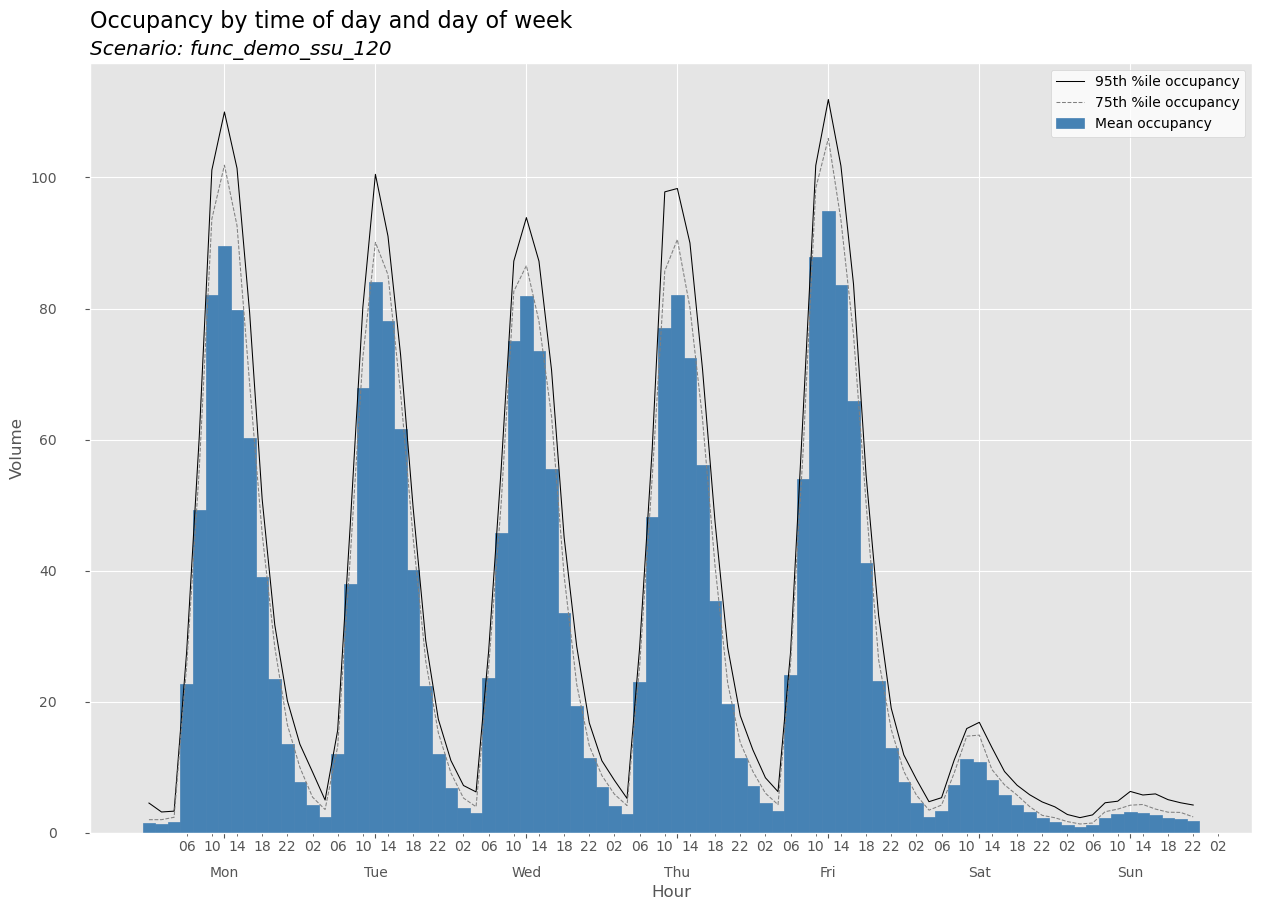

In [18]:
# Required inputs
scenario_name = 'func_demo_ssu_120'
in_field_name = 'InRoomTS'
out_field_name = 'OutRoomTS'
start_date = '2024-01-02'
end_date = '2024-09-30'

# Optional inputs
cat_field_name = 'PatType'
verbosity = 1  # INFO level logging
csv_export_path = './output'
plot_export_path = './output'
bin_size_minutes = 120

# Use legacy function interface
hills = hm.make_hills(scenario_name=scenario_name, data=stops_df,
              in_field=in_field_name, out_field=out_field_name,
              start_analysis_dt=start_date, end_analysis_dt=end_date,
              cat_field=cat_field_name,
              bin_size_minutes=bin_size_minutes,
              csv_export_path=csv_export_path, plot_export_path=plot_export_path, verbosity=verbosity)

# Get and display occupancy plot
occ_plot = hm.get_plot(hills, 'occupancy')
occ_plot

This histogram looks "blockier" due to the two-hour bin sizes.

## Using the object oriented hillmaker API

For more control over hillmaker you can use the object oriented API. In this tutorial we'll just do a brief introduction. You can get more details in {doc}`using_oo_api`.

The main steps in using the API are:

- create a `Scenario` object initialized with your hillmaker inputs,
- call the `make_hills` method to run hillmaker and store the outputs in the `Scenario` object,
- use methods to retrieve `Dataframe` objects, plots and other outputs

Here's a brief example. We'll use the same inputs as in the first example, except for setting `bin_size_minutes=30`. By default, plots aren't automatically created or exported. We will use the `export_all_week_plots` argument to create and export just the weekly plots. There are a number of other input arguments that can be used for more detailed control of the hillmaker analysis process, but we'll hold off on that for now.

In [19]:
oo_demo_ssu_30 = hm.Scenario(scenario_name='oo_demo_ssu_30',
                             data=stops_df,
                             in_field='InRoomTS',
                             out_field='OutRoomTS',
                             start_analysis_dt='2024-01-02',
                             end_analysis_dt='2024-09-30',
                             cat_field='PatType',
                             bin_size_minutes=30,
                             plot_export_path='./output',
                             export_all_week_plots=True)

# Show datatype
type(oo_demo_ssu_30)

hillmaker.scenario.Scenario

Let's make some hills. By default, the `verbosity` parameter is set to 0 - we won't get any messages unless they are warnings or errors.

In [20]:
oo_demo_ssu_30.make_hills()

All of the outputs from running `make_hills` get stored in an attribute dictionary called `hills`.

In [21]:
oo_demo_ssu_30.hills.keys()

dict_keys(['bydatetime', 'summaries', 'los_summary', 'settings', 'plots', 'runtime'])

There are methods for retrieving specific items from this dictionary. For example, there is `get_plot`.

In [22]:
help(oo_demo_ssu_30.get_plot)

Help on method get_plot in module hillmaker.scenario:

get_plot(flow_metric: str = 'occupancy', day_of_week: str = 'week') method of hillmaker.scenario.Scenario instance
    Get plot object for specified flow metric and whether full week or specified day of week.
    
    Parameters
    ----------
    flow_metric : str
        Either of 'arrivals', 'departures', 'occupancy' ('a', 'd', and 'o' are sufficient).
        Default='occupancy'
    day_of_week : str
        Either of 'week', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'. Default='week'
    
    Returns
    -------
    plot object from matplotlib



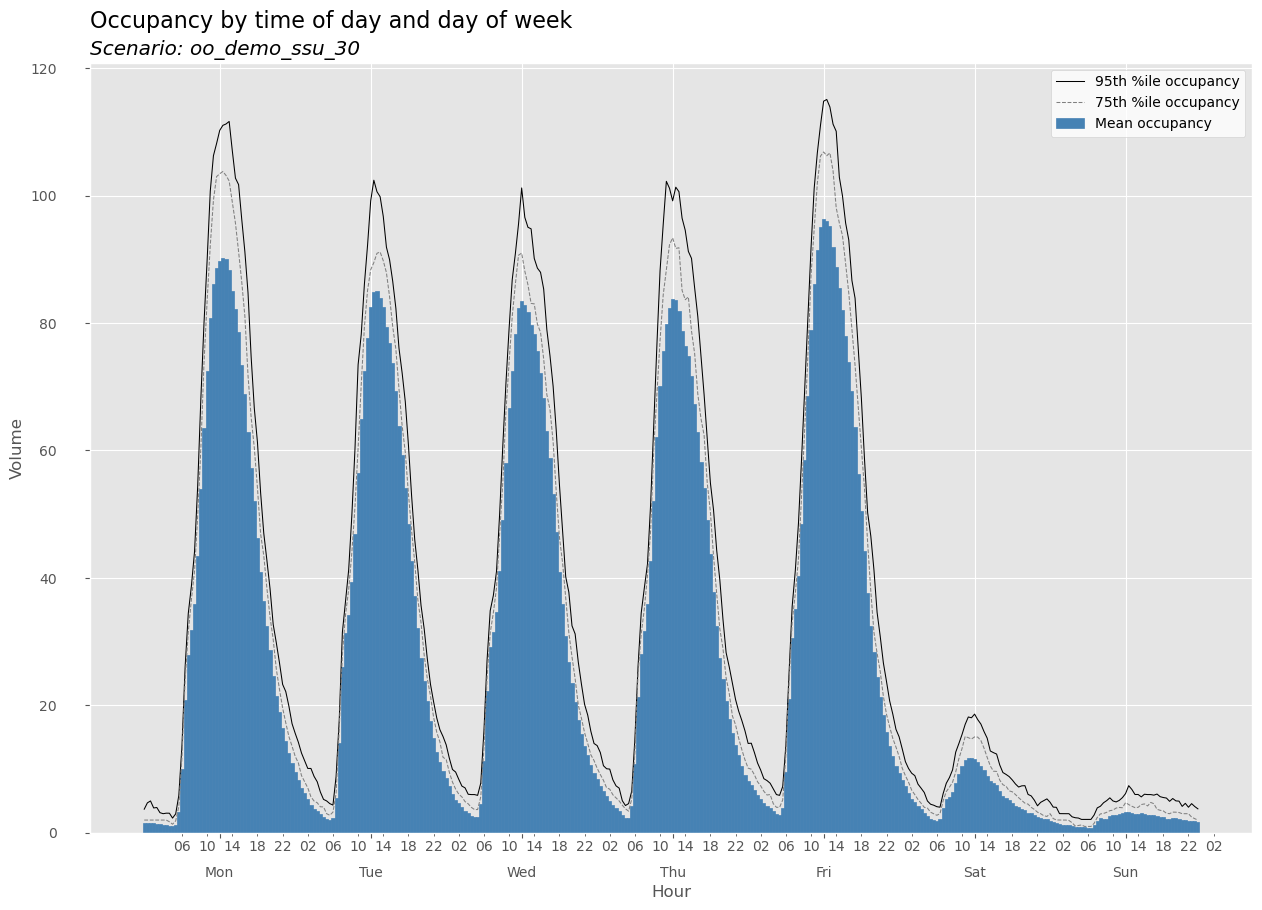

In [23]:
oo_demo_ssu_30.get_plot('occupancy')

Similarly, we can use `get_bydatetime_df` and `get_summary` to get at specific results `DataFrame` objects.

In [24]:
help(oo_demo_ssu_30.get_bydatetime_df)

Help on method get_bydatetime_df in module hillmaker.scenario:

get_bydatetime_df(by_category: bool = True) method of hillmaker.scenario.Scenario instance
    Get bydatetime dataframe
    
    Parameters
    ----------
    by_category : bool
        Default=True corresponds to category specific statistics. A value of False gives overall statistics.
    
    
    Returns
    -------
    DataFrame



In [25]:
oo_demo_ssu_30.get_bydatetime_df(by_category=False)

,arrivals,departures,occupancy,day_of_week,dow_name,bin_of_day_str,bin_of_day,bin_of_week
datetime,,,,,,,,
2024-01-02 00:00:00,0.0,0.0,1.000000,1,Tue,00:00,0,48
2024-01-02 00:30:00,0.0,0.0,1.000000,1,Tue,00:30,1,49
2024-01-02 01:00:00,0.0,0.0,1.000000,1,Tue,01:00,2,50
2024-01-02 01:30:00,0.0,1.0,0.766667,1,Tue,01:30,3,51
2024-01-02 02:00:00,0.0,0.0,0.000000,1,Tue,02:00,4,52
...,...,...,...,...,...,...,...,...
2024-09-30 21:30:00,1.0,7.0,19.700000,0,Mon,21:30,43,43
2024-09-30 22:00:00,0.0,3.0,15.366667,0,Mon,22:00,44,44
2024-09-30 22:30:00,1.0,4.0,11.433333,0,Mon,22:30,45,45


You may have noticed that there were a few other keys in the `hills` dictionary. For example, we can get a simple length of stay summary. The summary is comprised of two histogram plots and two tabular summaries - one each that are by category and one that is aggregated over all records in the stop data.

In [26]:
oo_demo_ssu_30.hills['los_summary']

{'los_stats': <pandas.io.formats.style.Styler at 0x7fc63faae680>,
 'los_histo': <Figure size 640x480 with 1 Axes>,
 'los_stats_bycat': <pandas.io.formats.style.Styler at 0x7fc63d0d0040>,
 'los_histo_bycat': <Figure size 900x600 with 5 Axes>}

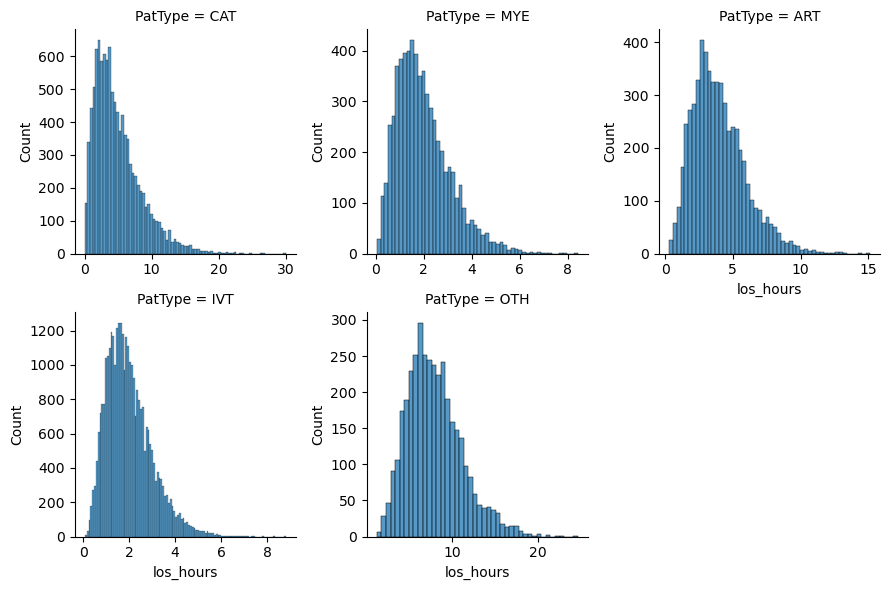

In [27]:
oo_demo_ssu_30.get_los_plot()

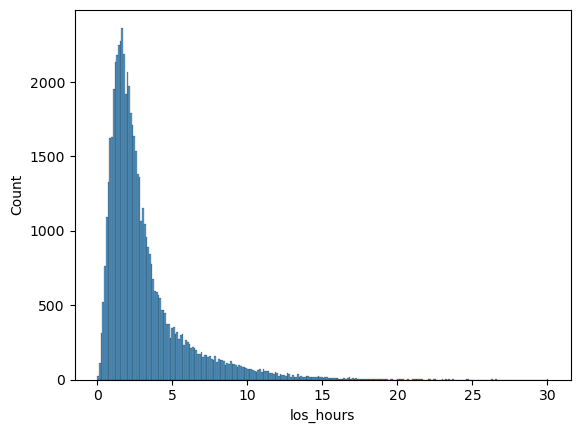

In [29]:
oo_demo_ssu_30.get_los_plot(by_category=False)

In [30]:
oo_demo_ssu_30.get_los_stats()

,count,mean,min,max,stdev,cv,skew,p50,p75,p95,p99
PatType,,,,,,,,,,,
ART,5761,4.0,0.3,15.1,2.0,0.5,1.0,3.7,5.1,7.7,9.9
CAT,10691,4.9,0.0,30.1,3.5,0.7,1.3,4.1,6.7,11.8,16.2
IVT,33174,2.0,0.1,8.8,1.0,0.5,1.0,1.8,2.5,3.9,5.0
MYE,6477,2.0,0.1,8.4,1.1,0.6,1.0,1.8,2.6,4.2,5.4
OTH,3767,7.9,1.2,24.7,3.2,0.4,0.8,7.5,9.8,14.1,17.2


In [31]:
oo_demo_ssu_30.get_los_stats(by_category=False)

,count,mean,min,max,stdev,cv,skew,p50,p75,p95,p99
all,59870,3.1,0.0,30.1,2.6,0.9,2.3,2.2,3.7,8.7,13.2


See {doc}`using_oo_api` for all the details on using the API.